# Deep-Q-Networks

This iPython notebook presents an OpenAI Gym environment <b>"Breakout-v0"</b> wherein the agent learns the temporal dynamics of the environment using concepts such as <b>Experience Replay</b>, <b>Double DQN</b> and <b>Dueling DQN</b>.

Import libraries

In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

/Users/yashwanthreddyvirupaksha/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load OpenAI Gym environment "Breakout-v0"

In [2]:
env = gym.make('Breakout-v0')

[2018-03-18 22:18:04,369] Making new env: Breakout-v0


Let's define a class for our neural network, this neural network is implemented on the concepts of Double DQN and Dueling DQN. 

In [3]:
class QNetwork():
    def __init__(self, h_size):
        #Each frame from the game is input to the neural network.
        #This input is passed through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None, 7056],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,1])
        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        #The output from the final convolutional is split into Advantage and Value Streams(Dueling DQN)
        self.streamAC, self.streamVC = tf.split(self.conv4, 2, 3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.action_space.n]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Combining together the Advantage and Value to get final Q-values
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Now we introduce the role of Double DQN: The loss function is calculated as the -
        #difference between target network and predicted Q-network.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.action_space.n,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.00015)
        self.updateModel = self.trainer.minimize(self.loss)

Experience Replay: 

We define a class for Experience Replay which stores experiences in the form of (state, action, reward, new state, done) which is then sampled to learn.

In [4]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

Utility function: To flatten the game frame obtained from the OpenAI Gym environment.

In [5]:
class StateProcessor():
    """
    Processes a raw Atari images. Resizes it and converts it to grayscale.
    """
    def __init__(self):
        # Build the Tensorflow graph
        with tf.variable_scope("state_processor"):
            self.input_state = tf.placeholder(shape=[210, 160, 3], dtype=tf.uint8)
            self.output = tf.image.rgb_to_grayscale(self.input_state)
            self.output = tf.image.crop_to_bounding_box(self.output, 34, 0, 160, 160)
            self.output = tf.image.resize_images(
                self.output, [84, 84], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            self.output = tf.squeeze(self.output)
            
    def process(self, sess, state):
        """
        Args:
            sess: A Tensorflow session object
            state: A [210, 160, 3] Atari RGB State
        Returns:
            A processed [84, 84, 1] state representing grayscale values.
        """
        #return sess.run(self.output, { self.input_state: state })
        return np.reshape(sess.run(self.output, { self.input_state: state }), [7056])

Utility funciton: As part of the theory with Double DQN we update the target network with those obtained through the primary network

In [6]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

Training the Deep-Q-Network:

Hyper-parameters

In [7]:
batch_size = 32 #The number of experiences for each training step.
update_freq = 4 #The frequency with which the target network is updated.
y = 0.99 #Discount factor( in bellman equation)
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #The number of steps of training to reduce startE to endE.
num_episodes = 1000000 #The number of episodes of game environment to train network with.
pre_train_steps = 20000 #How many steps of random actions before training begins.
max_epLength = 500 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [44]:
tf.reset_default_graph()
mainQN = QNetwork(h_size)
targetQN = QNetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

state_processor = StateProcessor()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if(load_model == True):
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = state_processor.process(sess, s)
        #print(type(s))
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while(j < max_epLength): #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if(np.random.rand(1) < e or total_steps < pre_train_steps):
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d,_ = env.step(a)
            s1 = state_processor.process(sess, s1)
            #print(s1.shape)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if(total_steps > pre_train_steps):
                if e > endE:
                    e -= stepDrop
                
                if(total_steps % (update_freq) == 0):
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #print(np.array(trainBatch[:,3]).shape)
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Update the target network toward the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

[2018-03-18 14:54:49,264] From <ipython-input-43-5980c296afe4>:37: get_global_step (from tensorflow.contrib.framework.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.get_global_step


Saved Model
2544 1.4 1
4947 1.3 1
7208 1.0 1
9387 0.8 1
12221 1.9 0.8001099999999234
14855 1.7 0.5630499999998325
18097 2.6 0.2712699999998618
20336 0.6 0.09999999999985551
23808 1.6 0.09999999999985551
27356 1.0 0.09999999999985551


KeyboardInterrupt: 

Inference: 

Loading Model...
AxesImage(54,36;334.8x217.44)


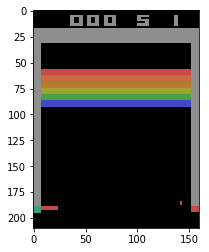

In [22]:
tf.reset_default_graph()
mainQN = QNetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

state_processor = StateProcessor()

jList = []
rList = []
total_steps = 0


with tf.Session() as sess:
    sess.run(init)
    
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess,ckpt.model_checkpoint_path)
    
    s = env.reset()
    s = state_processor.process(sess, s)
    
    rAll = 0
    j = 0
    frames = []
    for i in range(2):
        s = env.reset()
        frames.append(s)
        s = state_processor.process(sess, s)
        env.render()
        d = False
        j = 0
        while(j < 20):
            j += 1
            env.render()
            a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s,r,d,_ = env.step(a)
            frames.append(s)
            s = state_processor.process(sess, s)

print(plt.imshow(frames[20]))
        